# Objective

- Train and make predictions on an AutoML model based on a tabular dataset.

This  uses the following Google Cloud ML services and resources:
Vertex AI
AutoML Tabular
The steps performed include the following:

 - Create a Vertex AI model training job.
 - Train an AutoML Tabular model.
 - Deploy the model resource to a serving endpoint resource.
 - Make a prediction by sending data.
 - Undeploy the model resource.

# Installation of packages

In [ ]:
# Install the packages
! pip3 install --quiet --upgrade google-cloud-aiplatform \
                                 google-cloud-storage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 7.1 MB/s eta 0:00:00


In [ ]:
#Automatically restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

# Set your project ID

If you don't know your project ID, try the following:

- Run gcloud config list.
- Run gcloud projects list.

In [ ]:
PROJECT_ID = "{Paste your New projectID here from Google Cloud}}"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

Updated property [core/project].


In [ ]:
REGION = "{Paste your region}"  # @param {type: "string"}

# Authenticate your Google Cloud account

Depending on your Jupyter environment, you may have to manually authenticate. Follow the relevant instructions below.

1. Vertex AI Workbench

Do nothing as you are already authenticated.
2. Local JupyterLab instance, uncomment and run:

In [ ]:
! gcloud auth login

In [ ]:
!gcloud auth list  # This shows the active account
!gcloud config list project  # This shows the current project

# Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [ ]:
BUCKET_NAME = f"ANY PREFFERED NAME YOU WANT TO GIVE-{PROJECT_ID}-unique"  # You can change 'your-bucket-name' to something else if you prefer
BUCKET_URI = f"gs://{BUCKET_NAME}"

In [ ]:
!gsutil mb -l us-central1 $BUCKET_URI

## The Bucket has been created

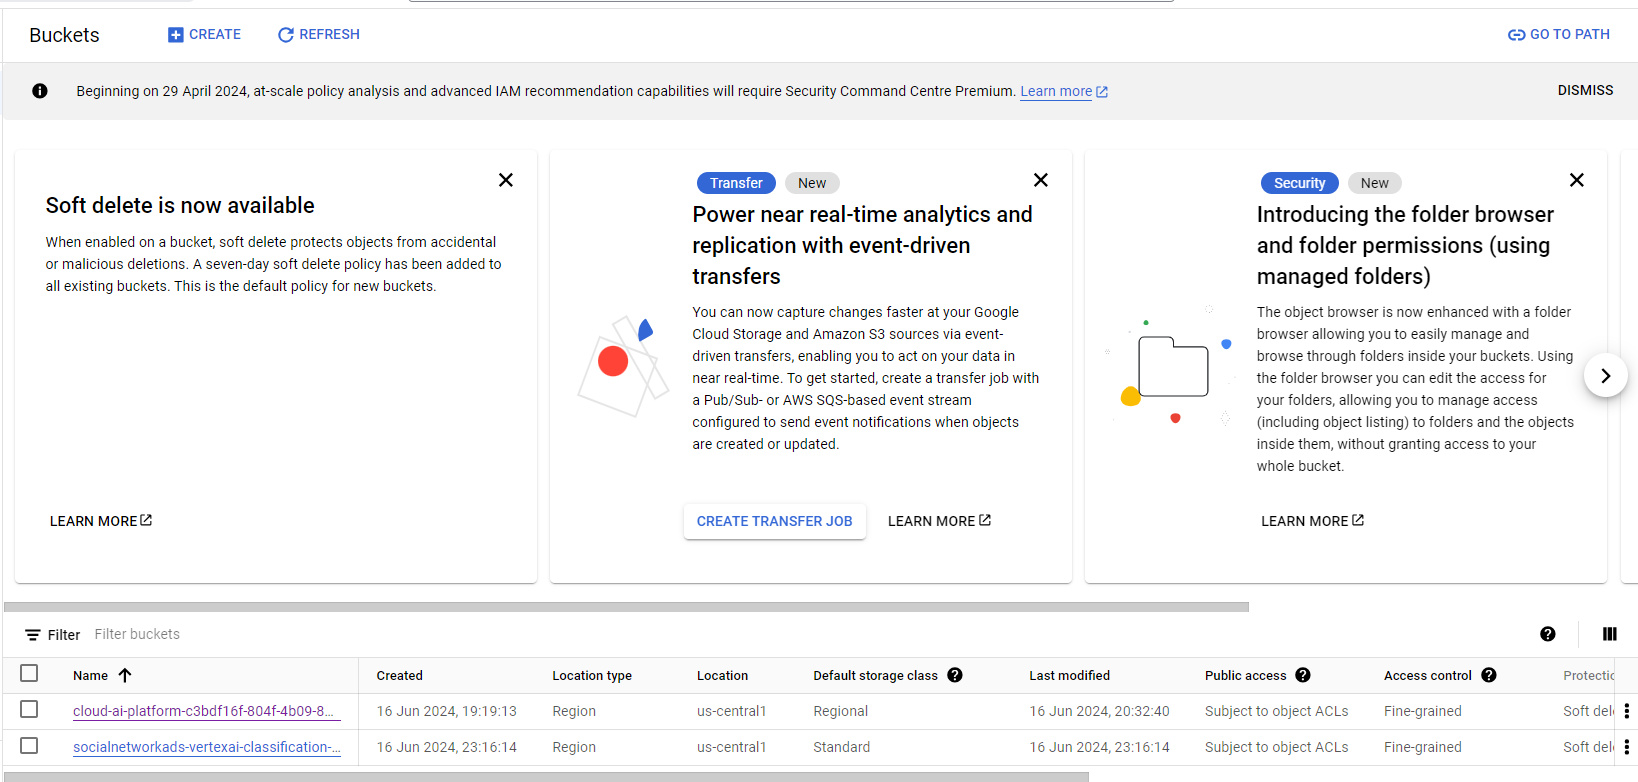

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!gsutil cp 'fILE_PATH TO YOUR CSV FILE FROM GOOGLE DRIVE' {BUCKET_URI}/data/


# Verify File Path for Future Reference
You will need the Google Cloud Storage path of this file for future operations, so set up a variable for it:

In [ ]:
gcs_source = f"{BUCKET_URI}/data/advertising.csv"

In [ ]:
import os

from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=REGION)

In [ ]:
gcs_source = f"gs://{BUCKET_URI}/data/advertising.csv"

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "DOWNLOADED JSON FILE  WHICH HAS CREDIENTIALS OF YOUR SUPPORT RESOURNCE MANAGER.json"

In [ ]:
!ls /content  # This will list all the files in the /content directory of Colab

In [ ]:
import os
print(os.getenv("GOOGLE_APPLICATION_CREDENTIALS"))
!cat $GOOGLE_APPLICATION_CREDENTIALS

In [ ]:
from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=REGION)

In [ ]:
ds = dataset = aiplatform.TabularDataset.create(
    display_name="advertising",
    gcs_source=gcs_source,
)

ds.resource_name

# The dataset has been created
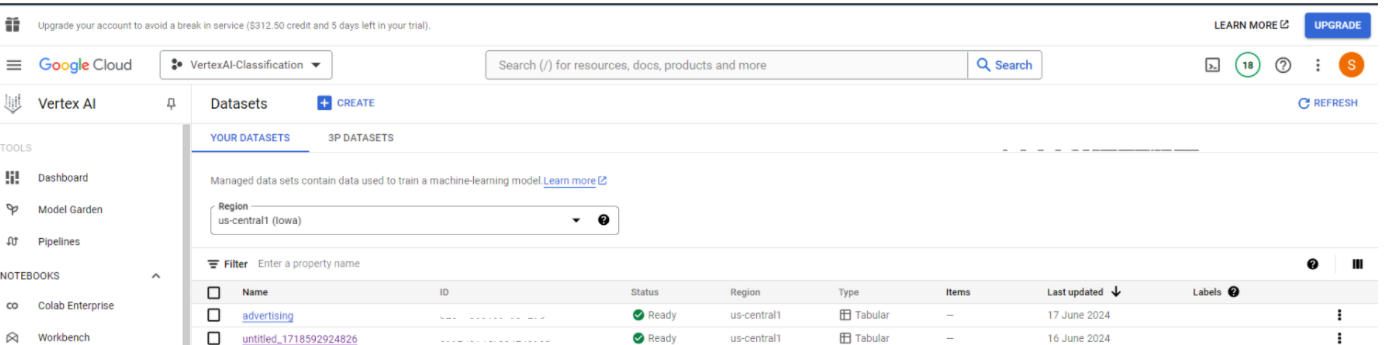

The code essentially configures a training job that will use Vertex AI's AutoML capabilities to automatically preprocess the data (as per the column transformations), train a model to predict the target variable (inferred from the context to be one of the columns, likely ClickedonAd), and optimize for classification outcomes.

This setup is crucial for automating many of the complex steps involved in machine learning, such as feature preprocessing and model selection, leveraging Google Cloud's powerful infrastructure and machine learning algorithms.

In [ ]:
from google.cloud import storage

storage_client = storage.Client()
buckets = list(storage_client.list_buckets())
print(buckets)

In [ ]:
job = aiplatform.AutoMLTabularTrainingJob(
    display_name="train-ads-automl-1",
    optimization_prediction_type="classification",
    column_transformations=[
        {"text": {"column_name": "AdTopicLine"}},
        {"numeric": {"column_name": "Age"}},
        {"numeric": {"column_name": "AreaIncome"}},
        {"text": {"column_name": "City"}},
        {"text": {"column_name": "Country"}},
        {"categorical": {"column_name": "ClickedonAd"}},
        {"numeric": {"column_name": "DailyTimespentonSite"}},
        {"numeric": {"column_name": "DailyInternetUsage"}},
        {"categorical": {"column_name": "Male"}},
        {"timestamp": {"column_name": "Timestamp"}},# Ensure this is the correct type
    ],
)


# You can see that train-ads-automl-1 is training
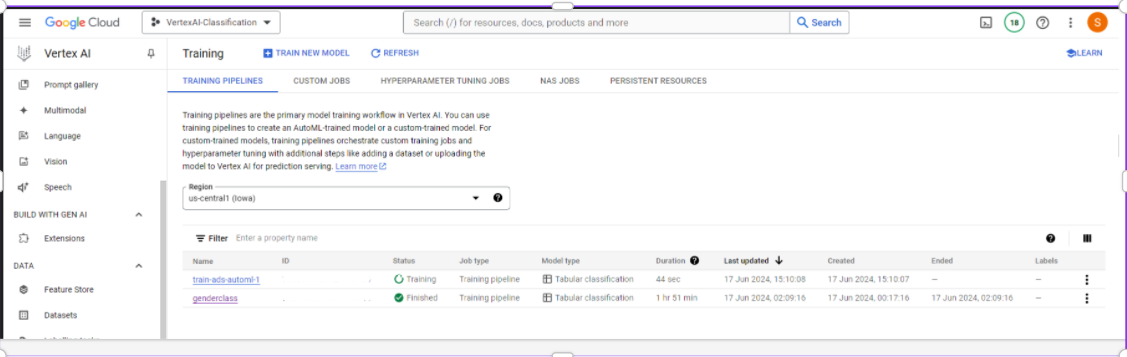


In [ ]:
# This takes about an hour to run
model = job.run(
    dataset=ds,
    target_column="ClickedonAd",
    training_fraction_split=0.8,
    validation_fraction_split=0.1,
    test_fraction_split=0.1,
    model_display_name="Ads-prediction-model",
    disable_early_stopping=False,
)

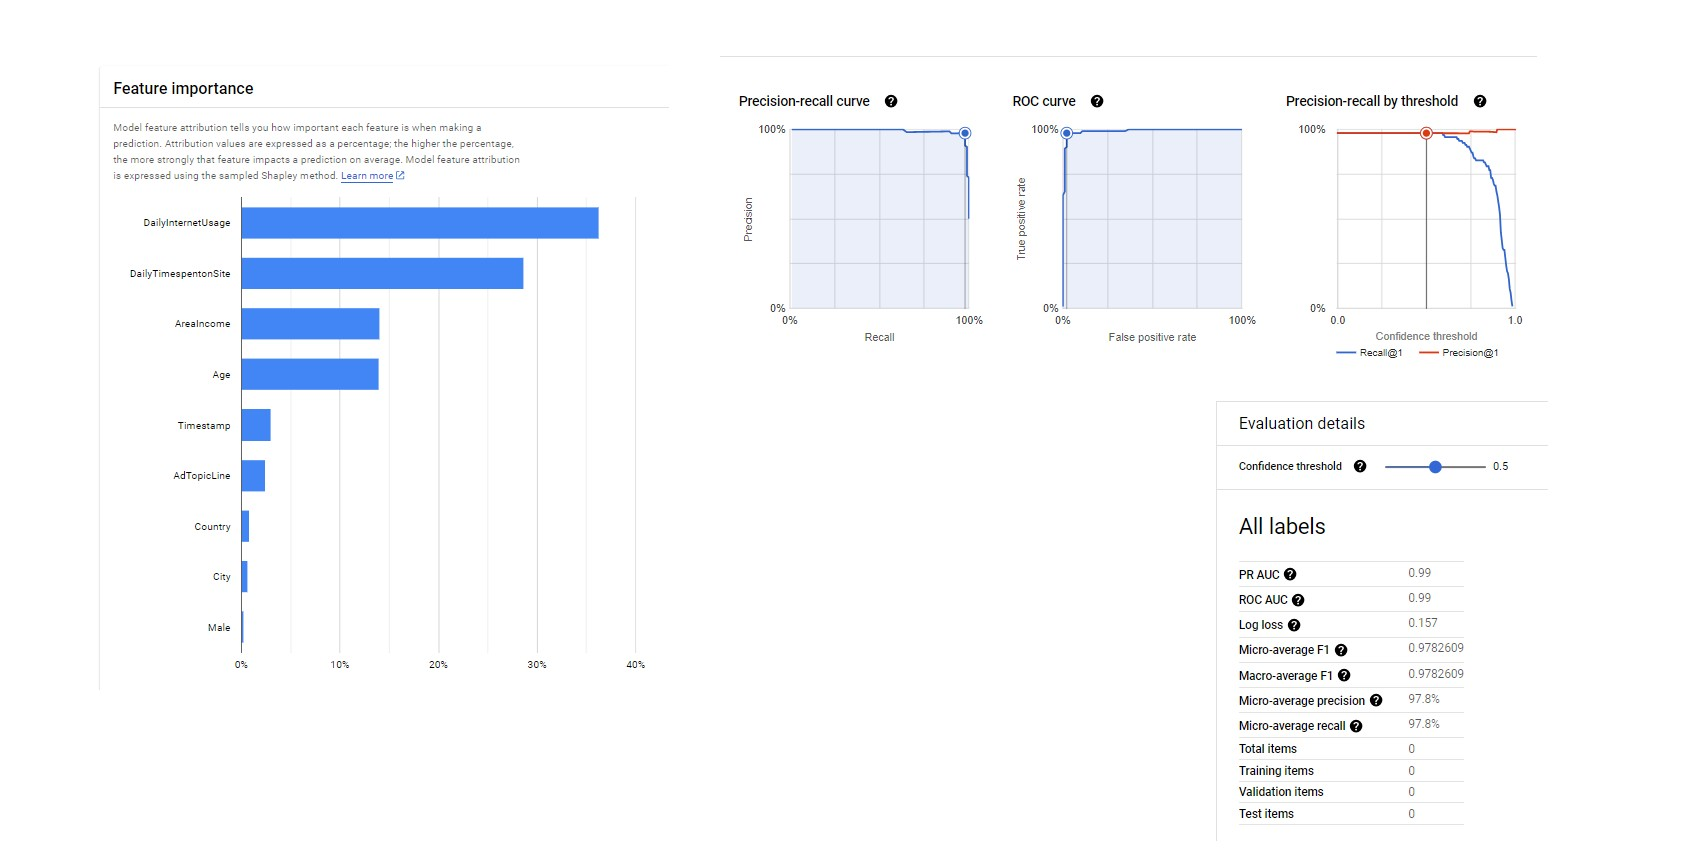

# Deploy your model
Before you use your model to make predictions, you need to deploy it to an endpoint. You can do this by calling the deploy function on the model resource. This function does two things:

1. Creates an endpoint resource to which the model resource is deployed.
2. Deploys the model resource to the endpoint resource.

Deploy your model.

NOTE: Wait until the model FINISHES deployment before proceeding to prediction.

In [ ]:
endpoint = model.deploy(
    machine_type="n1-standard-4",
)

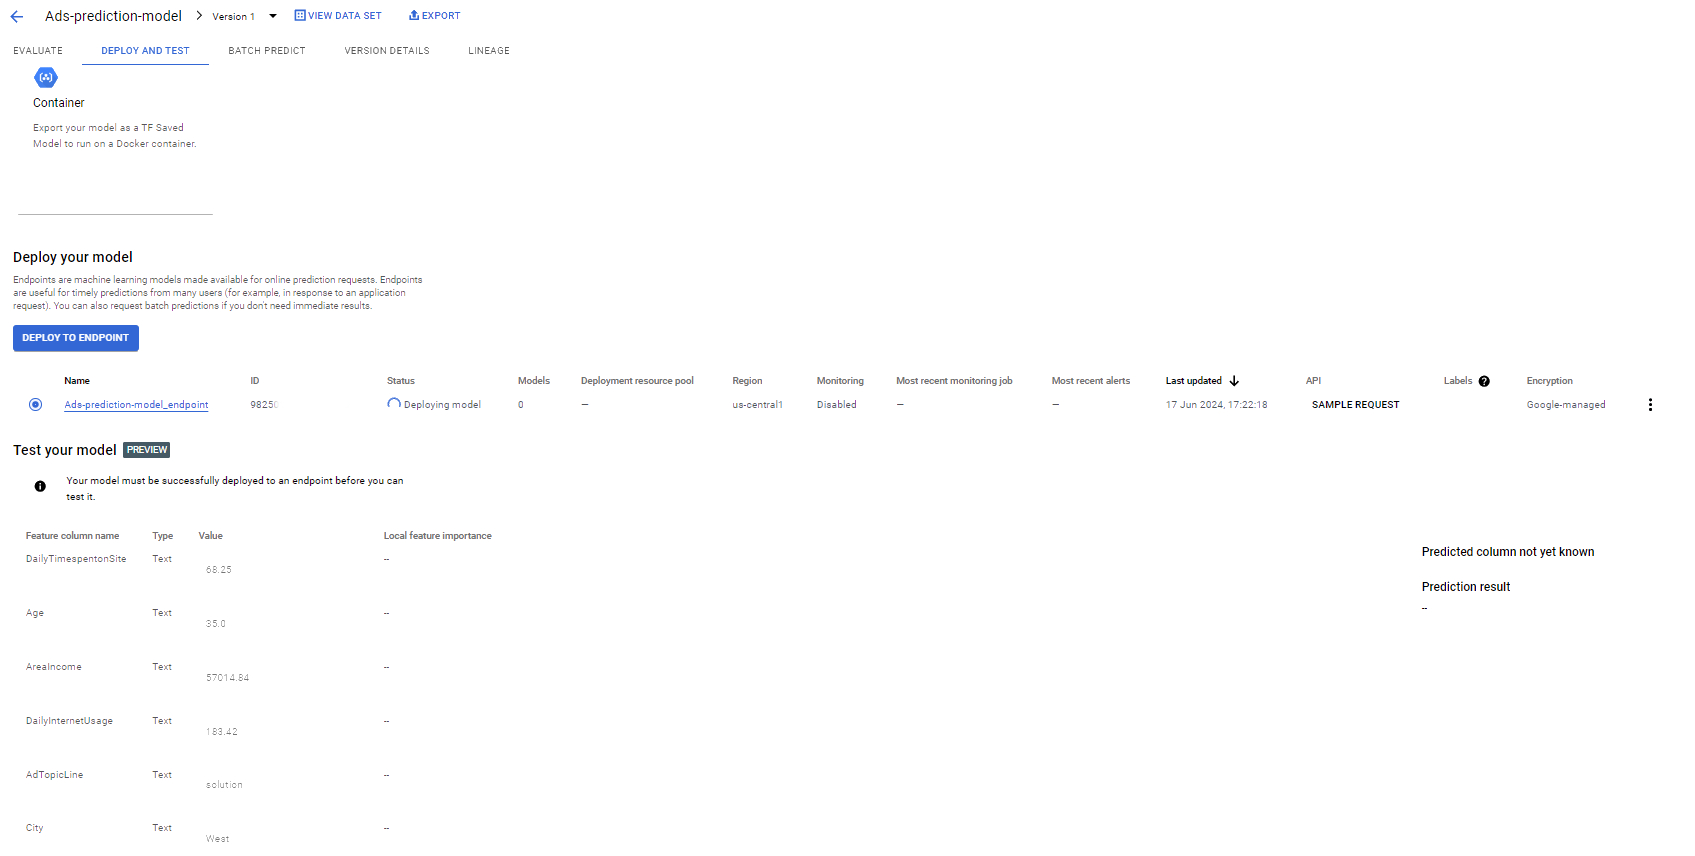



# Predict on the endpoint

1. This sample instance is taken from an observation in which Adopted = Yes

2. Note that the values are all strings. Since the original data was in CSV format, everything is treated as a string. The transformations you defined when creating your *AutoMLTabularTrainingJob* inform Vertex AI to transform the inputs to their defined types.

In [ ]:
prediction = endpoint.predict(
    [
        {
            "DailyTimespentonSite": "68.25",
            "Age": "35.0",
            "AreaIncome": "57014.84",
            "DailyInternetUsage": "183.42",
            "AdTopicLine": "solution",
            "City": "West",
            "Male": "0",
            "Country": "Island",
            "Timestamp": "4/10/2016 0:13"
        }
    ]
)

print(prediction)

Prediction(predictions=[{'classes': ['0', '1'], 'scores': [0.626486599445343, 0.373513400554657]}], deployed_model_id='873242030384349184', metadata=None, model_version_id='1', model_resource_name='projects/915536942979/locations/us-central1/models/3207839467687641088', explanations=None)


#Predicted results

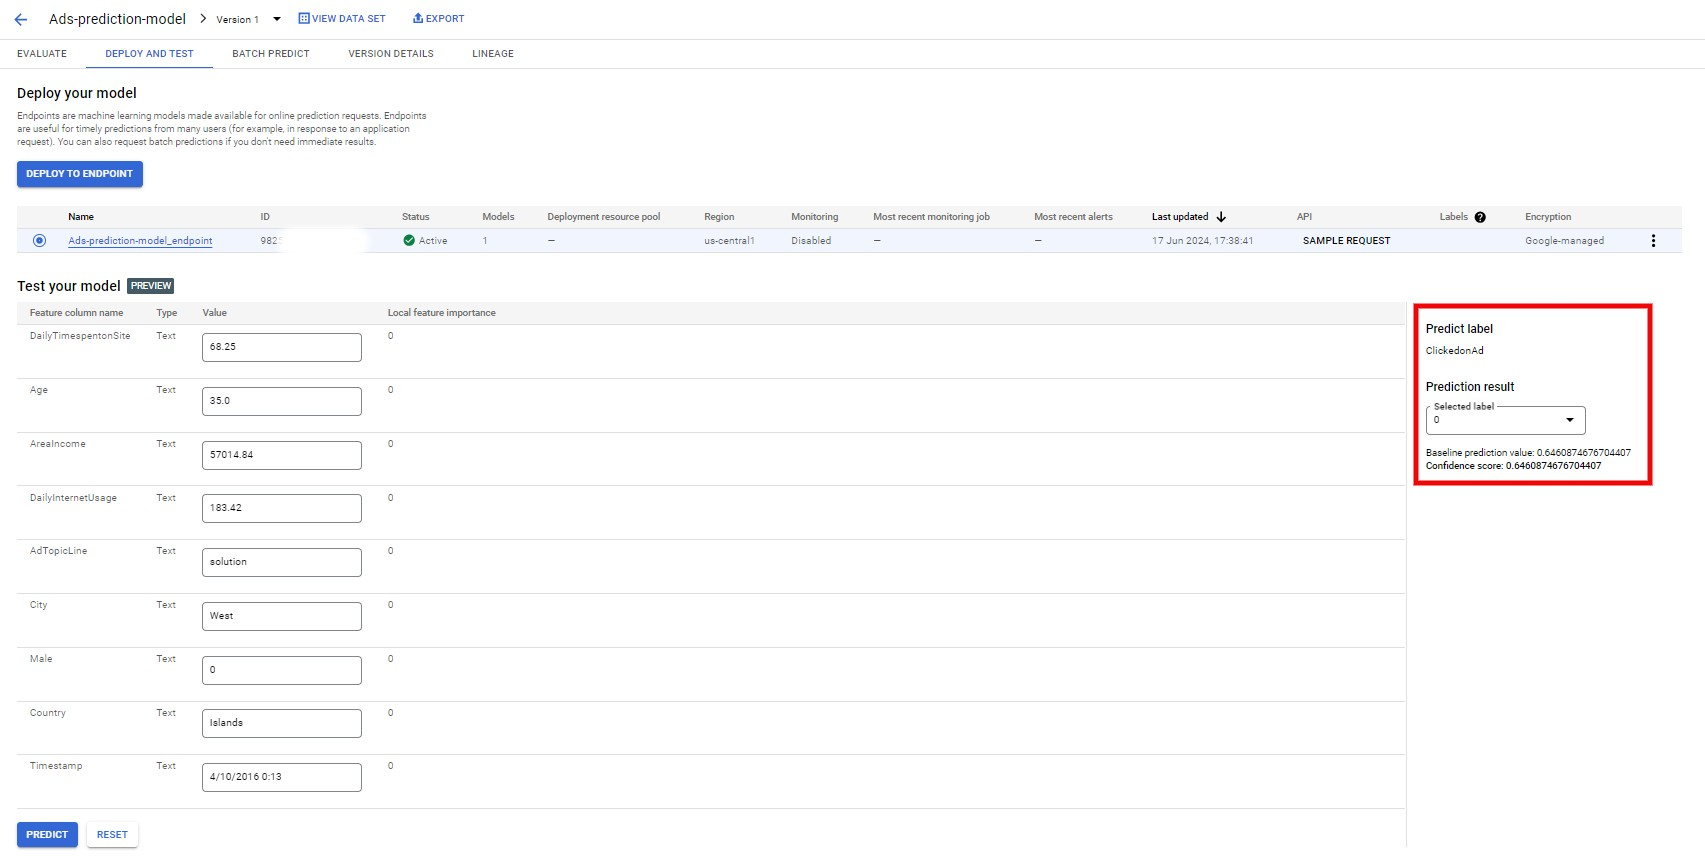

# Undeploy the model

To undeploy your model resource from the serving endpoint resource, use the endpoint's undeploy method with the following parameter:

- deployed_model_id: The model deployment identifier returned by the prediction service when the model resource is deployed. You can retrieve the deployed_model_id using the prediction object's deployed_model_id property.

In [ ]:
endpoint.undeploy(deployed_model_id=prediction.deployed_model_id)

# Cleaning up
To clean up all Google Cloud resources used in this project, you can delete the Google Cloud project you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

- Training Job
- Model
- Endpoint
- Cloud Storage Bucket

*Note*: You must delete any model resources deployed to the endpoint resource before deleting the endpoint resource.

In [ ]:
# Warning: Setting this to true will delete everything in your bucket
delete_bucket = False

# Delete the training job
job.delete()

# Delete the model
model.delete()

# Delete the endpoint
endpoint.delete()

if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil -m rm -r $BUCKET_URI

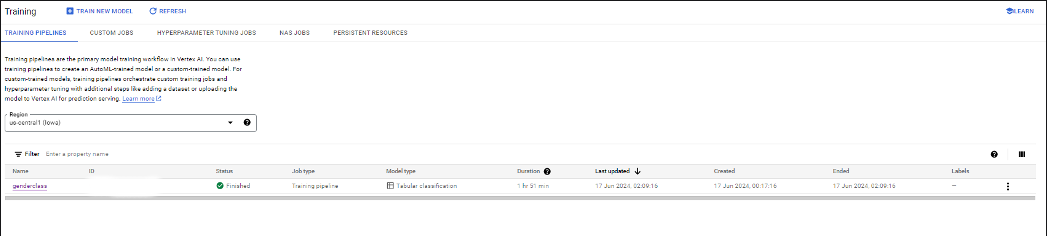